In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
jan_pd = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')
feb_pd = pd.read_parquet('../data/yellow_tripdata_2023-02.parquet')

In [3]:
# Read the data for January. How many columns are there?
print(f"January data has {jan_pd.shape[1]} columns")
# Read the data for February. How many columns are there?
print(f"February data has {feb_pd.shape[1]} columns")
print (jan_pd.shape)
print (feb_pd.shape)

January data has 19 columns
February data has 19 columns
(3066766, 19)
(2913955, 19)


In [4]:
rides_pd = pd.concat([jan_pd, feb_pd], ignore_index=True)
# Print shape and data columns types
print(rides_pd.shape)
print(rides_pd.dtypes)

(5980721, 20)
VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
Airport_fee                     float64
dtype: object


In [5]:
# Create new column 'duration' in minutes, using the difference between 'tpep_dropoff_datetime' and 'tpep_pickup_datetime'
jan_pd['duration'] = (jan_pd['tpep_dropoff_datetime'] - jan_pd['tpep_pickup_datetime']).dt.total_seconds() / 60

# print stats of the duration column
print(jan_pd.duration.describe())

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64


In [6]:
# Create new column 'duration' in minutes, using the difference between 'tpep_dropoff_datetime' and 'tpep_pickup_datetime'
rides_pd['duration'] = (rides_pd['tpep_dropoff_datetime'] - rides_pd['tpep_pickup_datetime']).dt.total_seconds() / 60

# print stats of the duration column
print(rides_pd.duration.describe())

count    5.980721e+06
mean     1.583802e+01
std      4.271559e+01
min     -4.361667e+01
25%      7.183333e+00
50%      1.165000e+01
75%      1.853333e+01
max      1.002918e+04
Name: duration, dtype: float64


In [7]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df = df[(df.duration >= 1) & (df.duration <= 60)]

# print stats of the duration column
print(df.duration.describe())


count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64


In [8]:
# Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
jan_pd2 = jan_pd[(jan_pd.duration >= 1) & (jan_pd.duration <= 60)]
print(f"January data: {jan_pd2.shape[0] / jan_pd.shape[0] * 100:.2f}% of records kept")

January data: 98.12% of records kept


In [9]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

jan_pd2[categorical] = jan_pd2[categorical].astype(str)

C:\Users\zarco\AppData\Local\Temp\ipykernel_17724\3612793948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jan_pd2[categorical] = jan_pd2[categorical].astype(str)


In [10]:
train_dicts = jan_pd2[categorical + numerical].to_dict(orient='records')
print(f"Number of records in train_dicts: {len(train_dicts)}")

Number of records in train_dicts: 3009173


In [11]:
print(train_dicts[0])

{'PULocationID': '161', 'DOLocationID': '141', 'trip_distance': 0.97}


In [12]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = jan_pd2[target].values

In [13]:
X_train.shape, y_train.shape

((3009173, 516), (3009173,))

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.658396474418433

C:\Users\zarco\AppData\Local\Temp\ipykernel_17724\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\zarco\AppData\Local\Temp\ipykernel_17724\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


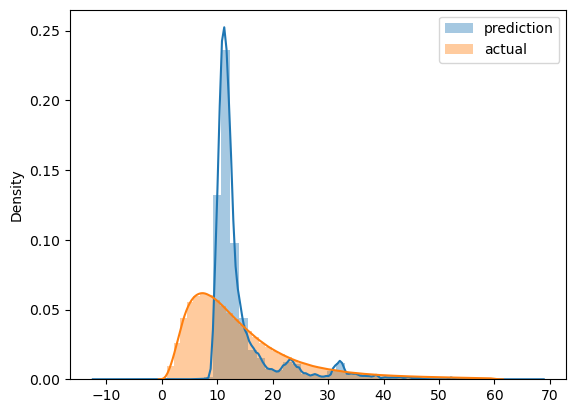

In [15]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

### VALIDATE MODEL

In [16]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    return df

In [17]:
# VALIDATION OF THE MODEL
df_train = read_dataframe('../data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2023-02.parquet')

In [18]:
len(df_train), len(df_val)

(3009173, 2855951)

In [19]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [20]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
print(X_train[0])
print(X_val[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 516)>
  Coords	Values
  (0, 43)	1.0
  (0, 325)	1.0
  (0, 515)	0.97
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 516)>
  Coords	Values
  (0, 67)	1.0
  (0, 304)	1.0
  (0, 515)	0.3


In [22]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

#### Linear Regression

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_val = lr.predict(X_val)
y_pred_train = lr.predict(X_train)

In [24]:
print(root_mean_squared_error(y_train, y_pred_train))
print(root_mean_squared_error(y_val, y_pred_val))

7.658396474418433
7.820267421957621


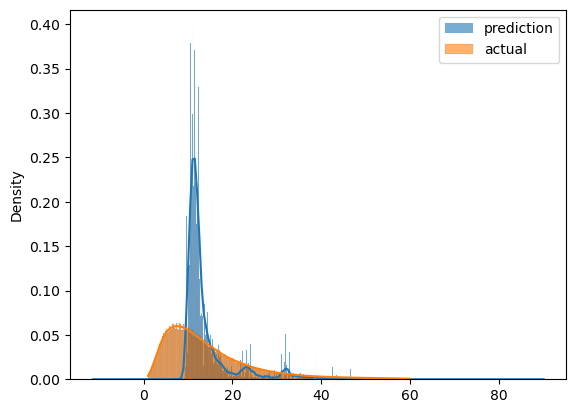

In [25]:
sns.histplot(y_pred_val, kde=True, stat="density", label='prediction', color="C0", alpha=0.6)
sns.histplot(y_val,  kde=True, stat="density", label='actual',     color="C1", alpha=0.6)
plt.legend()

In [26]:
os.makedirs('models', exist_ok=True)
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

#### Lasso

In [27]:
lr = Lasso(0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

8.750249485260136

In [ ]:
sns.histplot(y_pred, kde=True, stat="density", label='prediction', color="C0", alpha=0.6)
sns.histplot(y_val,  kde=True, stat="density", label='actual',     color="C1", alpha=0.6)
plt.legend()

In [28]:
os.makedirs('models', exist_ok=True)
with open('models/lasso.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

#### Ridge

In [29]:
rg = Ridge(alpha=0.1, solver='auto', random_state=1, max_iter=1000)
rg.fit(X_train, y_train)

y_pred_rg = rg.predict(X_val)
root_mean_squared_error(y_val, y_pred_rg)

7.812912381802727

In [ ]:
sns.histplot(y_pred, kde=True, stat="density", label='prediction', color="C0", alpha=0.6)
sns.histplot(y_val,  kde=True, stat="density", label='actual',     color="C1", alpha=0.6)
plt.legend()

In [30]:
os.makedirs('models', exist_ok=True)
with open('models/ridge.bin', 'wb') as f_out:
    pickle.dump((dv, rg), f_out)